# Simplified Workflow (Real Normalized Data)

In [1]:
import mne
import numpy as np 
import matplotlib.pyplot as plt
import torch
import os
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms 
import pyedflib


## Loading the data

In [2]:
# save numpy array to EDF file
def save_numpy_array_to_edf(array_data, fileName):
    n_channels = array_data.shape[1]
    f = pyedflib.EdfWriter(fileName, n_channels=n_channels)

    ch_labels = ["Fc5.", "Fc3.", "Fc1.", "Fcz.", "Fc2.", "Fc4.", "Fc6.", "C5.", "C3.", "C1.", "Cz.", "C2.", "C4.", "C6.", "Cp5.", "Cp3.", "Cp1.", "Cpz.", "Cp2.", "Cp4."]

    # set channel information
    for i in range(n_channels):
        channel_info = None
        if i < len(ch_labels):
            channel_info = {'label': ch_labels[i], 'sample_rate': 160.0}
        else:
            channel_info = {'label': "EEG" + str(i), 'sample_rate': 160.0} 
        f.setSignalHeader(i, channel_info)

    # iterate over each sample
    for i in range(array_data.shape[0]):
        # for each channel in the sample
        for j in range(n_channels):
            # flatten the array for the current channel, convert to float64 and write into edf file
            f.writePhysicalSamples(array_data[i, j, :].astype(np.float64))

    f.close()

generated_closed = np.load("../data/training/normalized-training-closed-64ch.npy")
generated_open = np.load("../data/training/normalized-training-open-64ch.npy")

GENERATED_EYES_OPEN = '../data/training/normalized-training-open-64ch.edf'
GENERATED_EYES_CLOSED = '../data/training/normalized-training-closed-64ch.edf'

save_numpy_array_to_edf(generated_closed, GENERATED_EYES_CLOSED)
save_numpy_array_to_edf(generated_open, GENERATED_EYES_OPEN)


# ch_names = ['EEG {0}'.format(i) for i in range(64)] 
# ch_types = ['eeg' for _ in range(64)]
# info = mne.create_info(ch_names=ch_names, sfreq=160.0, ch_types=ch_types)

# generated_closed_mne = []
# for i in range(len(generated_closed)):
#     generated_closed_mne.append(mne.io.RawArray(generated_closed[i], info))

# generated_open_mne = []
# for i in range(len(generated_open)):
#     generated_open_mne.append(mne.io.RawArray(generated_open[i], info))


## Plot EEG signals for multiple channels

Extracting EDF parameters from c:\Users\joshua.park\Desktop\eeg-wgan\data\training\EEGData\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Event: T0, Count: 1
Extracting EDF parameters from c:\Users\joshua.park\Desktop\eeg-wgan\data\training\normalized-training-open-64ch.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6719  =      0.000 ...    41.994 secs...
eyes open
Using matplotlib as 2D backend.


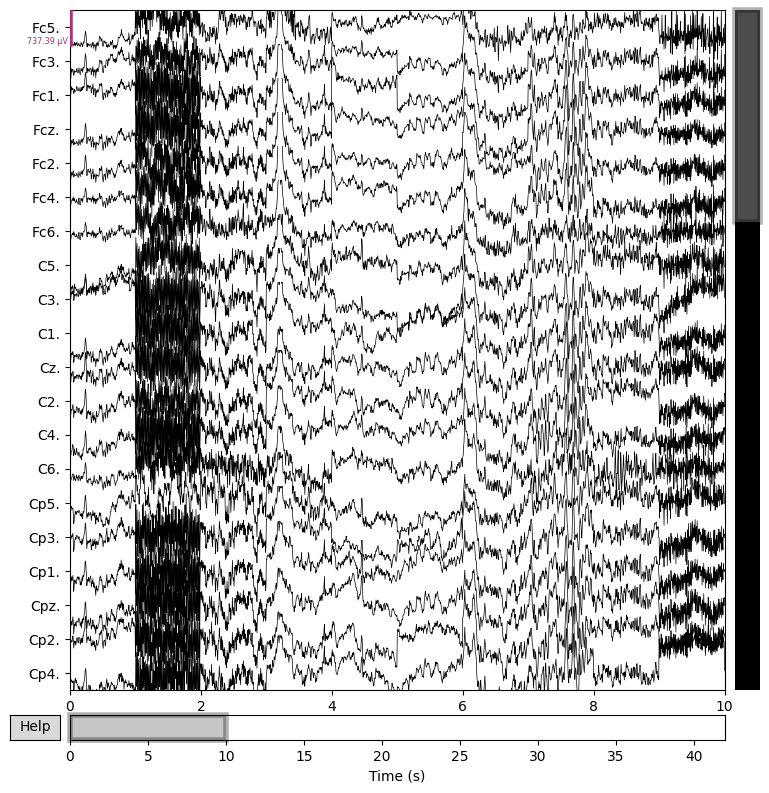

Effective window size : 12.800 (s)
Extracting EDF parameters from c:\Users\joshua.park\Desktop\eeg-wgan\data\training\normalized-training-closed-64ch.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7199  =      0.000 ...    44.994 secs...
eyes closed


C:\Users\joshua.park\AppData\Local\Temp\ipykernel_11904\743245210.py:21: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
c:\Users\joshua.park\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


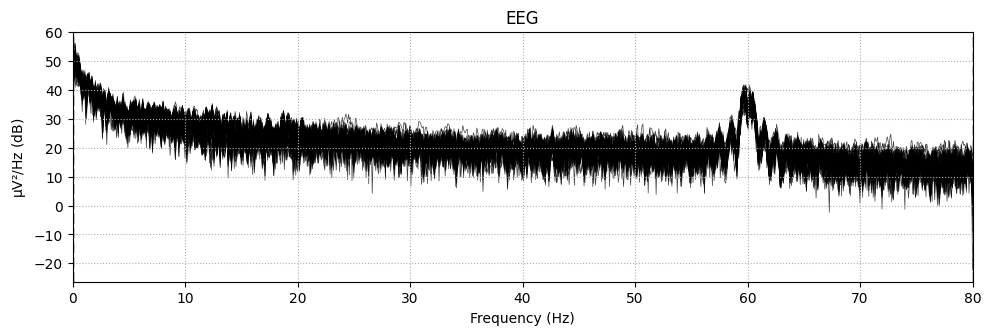

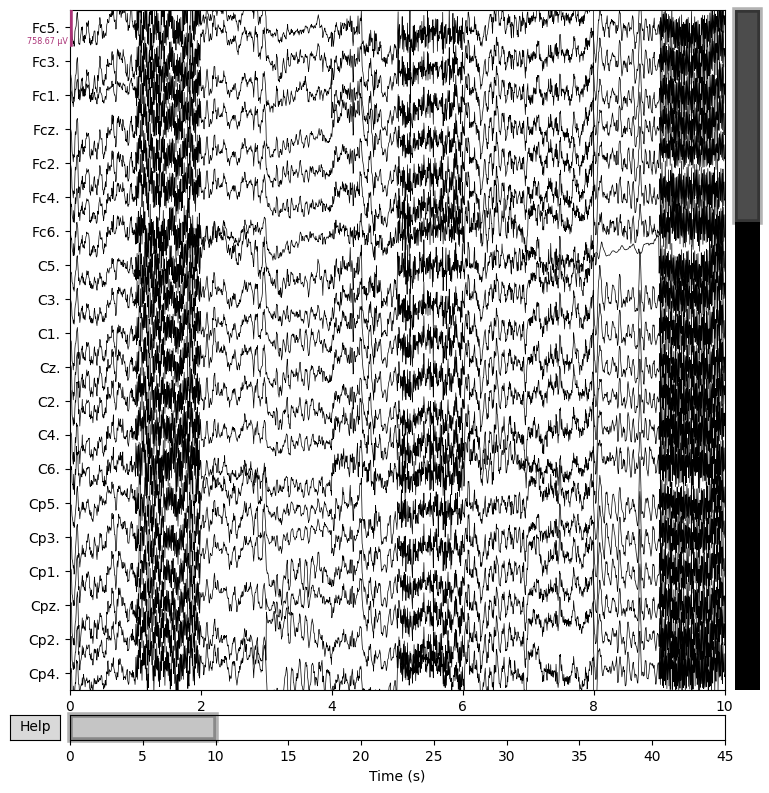

Effective window size : 12.800 (s)
EEG data shape: (64, 7200)


C:\Users\joshua.park\AppData\Local\Temp\ipykernel_11904\743245210.py:26: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
c:\Users\joshua.park\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


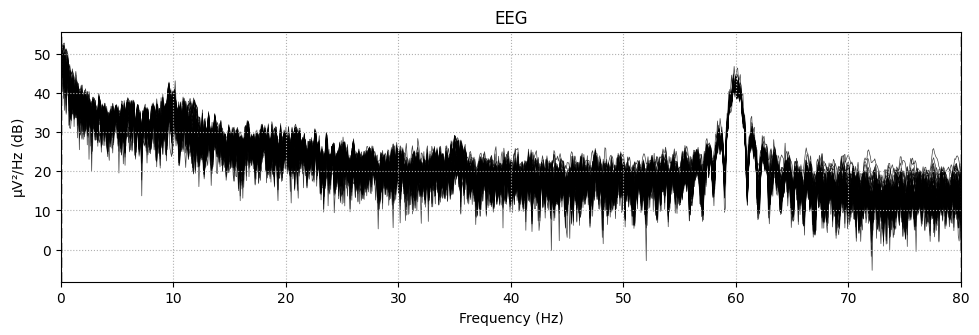

In [3]:
annotations = mne.io.read_raw_edf('../data/training/EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf', preload=True).annotations

event_descriptions, event_counts = np.unique(annotations.description, return_counts=True)

# Print event descriptions and their counts
for desc, count in zip(event_descriptions, event_counts):
    print(f"Event: {desc}, Count: {count}")

# Select specific event type (replace 'event_type' with your desired event description)
event_type = 'event_type'
events = annotations[annotations.description == event_type]

# Print out event onset times and durations
for idx, event in enumerate(events):
    print(f"Event {idx + 1}: Onset: {event['onset']:.2f}, Duration: {event['duration']:.2f}")

# Replace 'your_file.edf' with the actual path to your EDF file
raw =  mne.io.read_raw_edf(GENERATED_EYES_OPEN, preload=True) # eyes open
print("eyes open")
raw.plot(scalings='auto', title='EEG Channels')
raw.compute_psd().plot()

raw =  mne.io.read_raw_edf(GENERATED_EYES_CLOSED, preload=True) # eyes closed
print("eyes closed")
raw.plot(scalings='auto', title='EEG Channels')
raw.compute_psd().plot()

# Get EEG data for all channels
eeg_data = raw.get_data()

# Print the shape of the EEG data array
print("EEG data shape:", eeg_data.shape)


# # List of EDF file paths
# edf_files = ['../data/training/EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf', 
# '../data/training/EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf',
# '../data/training/EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf']

# # List comprehension to read all EDF files
# raw_list = [mne.io.read_raw_edf(edf_file, preload=True) for edf_file in edf_files]


# # Extract EEG data for all channels from each raw object
# eeg_data_list = [raw.get_data() for raw in raw_list]

# # Print the shape of the EEG data arrays for each file
# for idx, eeg_data in enumerate(eeg_data_list):
#     print(f"EEG data shape for file {edf_files[idx]}:", eeg_data.shape)

# raw_list[0].plot(scalings='auto', title='EEG Channels')

## Visualizing the Data

In [4]:
# raw.compute_psd(fmax=50).plot(picks="data", exclude="bads")
# raw.plot(duration=5, n_channels=30)

In [5]:
# def basic_plot(file_path):
#     data = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
#     eeg_data = data.get_data()
#     time = data.times
#     plt.figure(figsize=(10, 6))
#     for ch_idx in range(eeg_data.shape[0]):
#         plt.plot(time, eeg_data[ch_idx], label=f'Channel {ch_idx + 1}')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude')
#     plt.title('EEG Data for All Channels')
#     return plt.show()

# print("eyes open")
# basic_plot('../data/training/EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R01.edf')
# print("eyes closed")
# basic_plot('../data/training/EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R02.edf')



In [4]:


def double_plot(file1, file2):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle('Eyes Opened vs Eyes Closed')

    data1 = mne.io.read_raw_edf(file1, preload=True, verbose=False)
    data1.filter(1.0, 30.0, fir_design="firwin", skip_by_annotation="edge", verbose=False)
    ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800, verbose=False)
    ica.fit(data1, verbose=False)
    ica.exclude = [1, 2]
    data1 = ica.apply(data1, verbose=False)

    
    data2 = mne.io.read_raw_edf(file2, preload=True, verbose=False)
    data2.filter(1.0, 30.0, fir_design="firwin", skip_by_annotation="edge", verbose=False)
    ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800, verbose=False)
    ica.fit(data2, verbose=False)
    ica.exclude = [1, 2]
    data2 = ica.apply(data2, verbose=False)
    

    good_channels1 = data1.info['ch_names']
    good_channels2 = data2.info['ch_names']

    eeg_data1 = data1.get_data(picks=good_channels1)
    eeg_data2 = data2.get_data(picks=good_channels2)

    time = data1.times

    ax1.plot(time, eeg_data1[0])
    ax1.set_title('Eyes Opened')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    for ch_idx in range(eeg_data1.shape[0]):
        ax1.plot(time, eeg_data1[ch_idx], label=f'Channel {ch_idx + 1}')
    ax1.set_xlim(0, 30)
    ax1.set_ylim(-0.001, 0.001)

    ax2.plot(time, eeg_data2[0])
    ax2.set_title('Eyes Closed')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude')
    for ch_idx in range(eeg_data2.shape[0]):
        ax2.plot(time, eeg_data2[ch_idx], label=f'Channel {ch_idx + 1}')
    ax2.set_xlim(0, 30)
    ax2.set_ylim(-0.001, 0.001)
    return plt.show()

double_plot(GENERATED_EYES_OPEN, GENERATED_EYES_CLOSED)

ValueError: x and y must have same first dimension, but have shapes (6720,) and (7200,)

In [ ]:

def compute_psd(data, fs, nperseg=256, noverlap=None):
    """
    Compute Power Spectral Density (PSD) using the Welch method.

    Parameters:
        data (array): EEG data array with shape (n_channels, n_samples).
        fs (float): Sampling frequency.
        nperseg (int): Length of each segment for PSD estimation.
        noverlap (int): Number of overlapping samples between segments.
    
    Returns:
        freqs (array): Frequency values.
        psd (array): Power Spectral Density values.
    """
    n_channels, n_samples = data.shape
    psd = np.zeros((n_channels, nperseg // 2 + 1))

    for ch_idx in range(n_channels):
        f, Pxx = plt.psd(data[ch_idx], Fs=fs, NFFT=nperseg, noverlap=noverlap)
        # Add a small epsilon to avoid zero values
        psd[ch_idx] = Pxx + 1e-10

    return f, psd

def average_across_arrays(generated_data):
    return generated_data.mean(axis=0)

def plot_psd(eeg_data):
    # Set the sampling frequency
    fs = raw.info['sfreq']
    print("sampling frequency: ", fs)

    # Compute PSD using the custom function
    freqs, psd = compute_psd(eeg_data, fs)

    # Plot the PSD
    plt.figure(figsize=(10, 6))  # Add this line to create a single figure
    for ch_idx in range(eeg_data.shape[0]):
        plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()


plot_psd(raw.get_data()) # Get the EEG data using .get_data()


In [ ]:
eeg_data = raw.get_data()
time = raw.times

# Plot EEG data for all channels using Matplotlib
plt.figure(figsize=(10, 6))
for ch_idx in range(eeg_data.shape[0]):
    plt.plot(time, eeg_data[ch_idx], label=f'Channel {ch_idx + 1}')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EEG Data for All Channels')
plt.show()

### Machine Learning with MNE

In [ ]:
# DEfine the time window for epochs around the events
t_min, t_max = -1., 4.

# Dictionary that maps event names to their corresponding event codes.
# Event codes are numeric identifiers that are used to label different type of events or triggers in EEG/MEG data.
event_id = {'hands': 2, 'feet': 3}

# This is the subject we choose to study. Can be in the range of 1-109 (inclusive)
subject = 1

# This is the run we choose to study. Can be in the range of 1-14 (inclusive)
runs = [6, 10, 14]  # motor imagery: hands vs feet

# Loads in the subject and runs you're interested in
raw_fnames = mne.datasets.eegbci.load_data(subject, runs, '../data/training/EEGData', verbose=False)

# Loads in the data file then reads and concatenates the data into the `raw` object
raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f, preload=True, verbose=False) for f in raw_fnames])

# Set channel names in the EEG data
mne.datasets.eegbci.standardize(raw)

# This creates an info object that represents the 10/05 electrode positions 
montage = mne.channels.make_standard_montage("standard_1005")

# Attaches the montage to the raw data
raw.set_montage(montage)

# This applies a bandpass filter (finite impulse response) to the data and avoids filtering data near the edge
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

# This line extracts information from annotations present in the raw data.
# Annotations are labels attached to specific points in the data and usually represent events or important time segments.
events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

# This line selects specific channel types from the raw data
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

epochs = mne.Epochs(
    raw, # Datase
    events, # Events
    event_id, # Event ID
    t_min, # Start time
    t_max, # End time
    proj=True, # Apply SSP projection vectors
    picks=picks, # Channels to include
    baseline=None, # Baseline interval
    preload=True, # Load data into memory
)

# This creates a new epochs object by copying the original epochs object and cropping the time interval from 1 to 2 seconds.
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)

# This creates a numpy array that contains the labels for each epoch. 
# The labels are stored in the last column of the events array. 
# The labels are stored as integers, but we want them to be 0 and 1. 
# We can subtract 2 from the labels to get the desired values.
labels = epochs.events[:, -1] - 2

epochs.plot(n_channels=1, n_epochs=1, scalings='auto')

In [ ]:
# Define a monte-carlo cross-validation generator (reduce variance):
# Keeps track of an empty list called scores for the cross-validation procedure
scores = []
# This extracts the data as a numpy array from the MNE object
epochs_data = epochs.get_data()
# This extracts the data from the epochs_train object
epochs_data_train = epochs_train.get_data()
# This line creates a cross-validation (CV) generator using the ShuffleSplit method
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
# This line creates the actual cross-validation splits using the splits method of the CV generator
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

# This code above sets up a classification pipeline that includes CSP for feature extraction and LDA as the classifier
# It then performs cross-validation using the pipeline and prints the average classification accuracy and chance level of classification accuracy.
# This code aims to evaluate the performance of the classifier on the given EEG data and the corresponding labels using cross-validation

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [ ]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()